In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras 
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,BatchNormalization,SpatialDropout2D
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
sample_sub_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
train_data = '../input/planets-dataset/planet/planet/train-jpg'
test_data = '../input/planets-dataset/planet/planet/test-jpg'
additional_test = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'

In [4]:
# adding '.jpg' extension to 'image_name'
train_df['image_name'] = train_df['image_name'].apply(lambda x: x+'.jpg')
sample_sub_df['image_name'] = sample_sub_df['image_name'].apply(lambda x: x+'.jpg')
train_df['tags'] = train_df['tags'].apply(lambda x:x.split(' '))
train_df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [5]:
sample_sub_df['tags'] = sample_sub_df['tags'].apply(lambda x:x.split(' '))
sample_sub_df.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [6]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [7]:
!ls ../input/planets-dataset/planet/planet/test-jpg | wc -l

40669


In [8]:
!ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional/ | wc -l

20522


In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2,horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    subset='training',
    dataframe=train_df,
    directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/',
    x_col='image_name',
    y_col='tags',
    batch_size=64,
    seed=42,
    target_size=(128,128)   
)
validation_generator = train_datagen.flow_from_dataframe(
    subset='validation',
    dataframe=train_df,
    directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/',
    x_col="image_name",
    y_col="tags",
    batch_size=64,
    seed=42,
    target_size=(128,128)  
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_sub_df,
    directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/',
    x_col='image_name',
    seed=42,
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(128,128)  
)
additional_test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_sub_df,
    directory='/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional',
    x_col='image_name',
    seed=42,
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(128,128)
)

Found 32384 validated image filenames belonging to 17 classes.
Found 8095 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames.
Found 20522 validated image filenames.


In [11]:
# let's abitrarily view an image
x30 = train_generator[0][0][30]
y30 = train_generator[0][1][30]
print("each image's shape is {}".format(x30.shape))
print("each label's shape is {}".format(y30.shape))
print('we have {} batches'.format(len(train_generator)))
print('each batch has {} images/labels'.format(train_generator[0][0].shape[0]))
print('40669/128 is {:.2F}, so the last batch will have {} images/labels'.format(40669/128, train_generator[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 506 batches
each batch has 64 images/labels
40669/128 is 317.73, so the last batch will have 64 images/labels


In [12]:
vgg_model = VGG16(input_shape=(128,128,3),weights='imagenet',include_top=False)
model = Sequential([BatchNormalization(input_shape=(128,128,3)),vgg_model,Flatten(),Dropout(0.5),Dense(17, activation='sigmoid')])

2022-03-22 07:57:57.206454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 07:57:57.290229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 07:57:57.290919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 07:57:57.292351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
early_stop = EarlyStopping(patience=4,monitor='val_loss')
modelcheckpoints = ModelCheckpoint(filepath='trainmodel.hdf5',save_best_only=True,save_weights_only=True)
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [14]:
# setting step size
step_train_size=train_generator.n//train_generator.batch_size
step_val_size=validation_generator.n//validation_generator.batch_size
step_test_size=test_generator.n//test_generator.batch_size
step_add_test_size = additional_test_generator.n//additional_test_generator.batch_size

In [15]:
# fitting model
model.fit(x=train_generator, steps_per_epoch=step_train_size, validation_data=validation_generator, validation_steps=step_val_size,epochs=20, callbacks=[early_stop,modelcheckpoints])

2022-03-22 07:58:00.470005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-22 07:58:02.282496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


506/506 [==============================] - 232s 440ms/step - loss: 0.1784 - accuracy: 0.0881 - val_loss: 0.1293 - val_accuracy: 0.0976
Epoch 2/20
506/506 [==============================] - 125s 247ms/step - loss: 0.1338 - accuracy: 0.1336 - val_loss: 0.1169 - val_accuracy: 0.1111
Epoch 3/20
506/506 [==============================] - 124s 246ms/step - loss: 0.1227 - accuracy: 0.1544 - val_loss: 0.1119 - val_accuracy: 0.1229
Epoch 4/20
506/506 [==============================] - 124s 244ms/step - loss: 0.1164 - accuracy: 0.1455 - val_loss: 0.1070 - val_accuracy: 0.1370
Epoch 5/20
506/506 [==============================] - 124s 245ms/step - loss: 0.1122 - accuracy: 0.1482 - val_loss: 0.1038 - val_accuracy: 0.1411
Epoch 6/20
506/506 [==============================] - 125s 248ms/step - loss: 0.1088 - accuracy: 0.1446 - val_loss: 0.1010 - val_accuracy: 0.1365
Epoch 7/20
506/506 [==============================] - 127s 251ms/step - loss: 0.1059 - accuracy: 0.1439 - val_loss: 0.1005 - val_accura

In [16]:
model.save('trialmodel.h5')

Text(0.5, 1.0, 'Loss Curves - after regularisation')

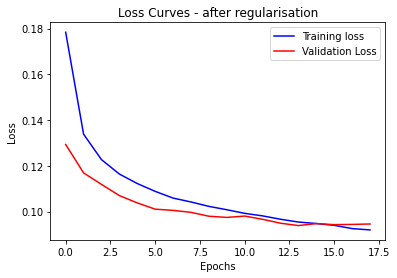

In [17]:
plt.figure()
plt.plot(model.history.history['loss'], 'blue')
plt.plot(model.history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after regularisation')

In [18]:
#reset the test generator
test_generator.reset()
pred = model.predict(test_generator, steps = step_test_size, verbose = 1)

40669/40669 [==============================] - 286s 7ms/step


In [19]:
pred[0]

array([1.5429836e-03, 2.3790868e-04, 6.5527775e-04, 3.1954858e-02,
       1.7160616e-03, 9.9552852e-01, 1.1015173e-04, 2.2945704e-04,
       2.1794538e-03, 7.9998455e-04, 1.7453356e-03, 1.8999098e-03,
       9.9991322e-01, 1.5131594e-03, 5.2123140e-03, 7.8870350e-04,
       1.9470850e-03], dtype=float32)

In [20]:
values = pred>0.2
values = values.astype(int)
values[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [21]:
inv_map = {j:i for i,j in train_generator.class_indices.items()}

In [22]:
tags = []
for a in range(len(values)):
  column = []
  for i in range(len(values[a])):
    if values[a][i] == 1:
      column.append(inv_map[i])
  tags.append(' '.join(column))

In [23]:
sample_sub_df[:40669]['tags'] = tags

In [24]:
additional_test_generator.reset()
add_pred = model.predict_generator(additional_test_generator,steps=step_add_test_size, verbose = 1)

20522/20522 [==============================] - 144s 7ms/step


In [25]:
values = add_pred>0.2
values = values.astype(int)
values[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [26]:
tags = []
for a in range(len(values)):
  column = []
  for i in range(len(values[a])):
    if values[a][i] == 1:
      column.append(inv_map[i])
  tags.append(' '.join(column))

In [27]:
len(tags)

20522

In [28]:
sample_sub_df[40669:]['tags'] = tags
sample_sub_df['image_name'] = sample_sub_df['image_name'].apply(lambda x:x[:-4])

In [29]:
#Saving predictions
sample_sub_df.to_csv('finalsubmission.csv',index=False)